In [1]:
import ebooklib
from ebooklib import epub
import re
import os

import enchant

import gensim
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import words, stopwords, names

import nltk
nltk.download('wordnet')
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

D:\DesignAPP\anaconda3\envs\demoEnvpy38\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\46981\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\46981\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import numpy as np
from scipy.sparse import random
from sklearn.decomposition import TruncatedSVD

In [32]:
import matplotlib.pyplot as plt

import tensorflow as tf
import PIL
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dropout, Dense, Softmax)
from tensorflow.keras.applications import mobilenet as _mobilenet
import random
import os
import numpy as np
from PIL import Image
import networkx as nx
from sklearn.neighbors import NearestNeighbors
from IPython.display import Image as iImage
from IPython.display import display
import math

import pickle
import scipy
from matplotlib import cm

# Extract paragraph

In [4]:
def merge_strings_until_limit(strings, min_length, max_length, test_for_max=0):
    merged_string = ""
    merged_strings = []

    for s in strings:
        if len(merged_string) <= min_length:
            merged_string += s
        elif len(merged_string) > max_length and test_for_max < 5:
            splitParagraph = merged_string.split('.')
            splitParagraphRePoint = []
            for sp in splitParagraph:
                splitParagraphRePoint.append(sp + '.')
            merged = merge_strings_until_limit(splitParagraphRePoint, min_length, max_length, test_for_max + 1)
            merged_strings.extend(merged)
            merged_string = s
        else:
            merged_strings.append(merged_string)
            merged_string = s

    if merged_string:
        merged_strings.append(merged_string)

    return merged_strings



In [5]:
def read_epub_paragraphs_from_folder(folder_path):
    all_paragraphs = []

    for filename in os.listdir(folder_path):
        if filename.endswith('.epub'):
            file_path = os.path.join(folder_path, filename)
            paragraphs = read_epub_paragraphs(file_path)
            all_paragraphs.extend(paragraphs)

    return all_paragraphs

In [6]:
def read_epub_paragraphs(epub_file):
    book_id = os.path.basename(epub_file)  # Extract filename from path
    book = epub.read_epub(epub_file)
    paragraphs = []

    for item in book.get_items():
        if item.get_type() == epub.ebooklib.ITEM_DOCUMENT:
            content = item.get_content().decode('utf-8')
            content = re.sub('<[^<]+?>', '', content)  # Remove HTML tags
            content = re.sub('\s+', ' ', content)  # Replace multiple whitespaces with a single space
            content = re.sub('\n', ' ', content)
            paragraphs.extend(content.strip().split("&#13;"))

    paragraphs = merge_strings_until_limit(paragraphs, 200, 1000)
    paragraphs = [paragraphs[i] for i in range(len(paragraphs)) if len(paragraphs[i]) > 50]
    return paragraphs[1:-1]

In [7]:
# Example usage:
folder_path = "./book"
paragraphs = read_epub_paragraphs_from_folder(folder_path)

D:\DesignAPP\anaconda3\envs\demoEnvpy38\lib\site-packages\ebooklib\epub.py:1395: UserWarning: In the future version we will turn default option ignore_ncx to True.
  warnings.warn('In the future version we will turn default option ignore_ncx to True.')


In [8]:
len(paragraphs)

1092

In [9]:
paragraphs[100]

' She didn’t have anyone to send to college anyway. She did, however, have Esther, her best friend and a professor at the law school, who was kind enough to check up on the house once a week. It was basically on the way from Pasadena, where she lived with her husband and nine-year-old son. Esther had written the previous night to say that all was well and that she hoped Adrianna was finally “getting busy” as she put it.'

# Vectorise text

In [10]:
processedDoc = paragraphs

In [11]:
processedDoc[0:5]

[' —“You! Inez!” by Alice Dunbar-Nelson, 1921  Contents Part One Chapter One Chapter Two Chapter Three Chapter Four Chapter Five Chapter Six Chapter Seven Chapter Eight Chapter Nine Chapter Ten Chapter Eleven',
 ' Chapter Twelve Chapter Thirteen Chapter Fourteen Chapter Fifteen Chapter Sixteen Part Two Chapter Seventeen Chapter Eighteen Chapter Nineteen Chapter Twenty Chapter Twenty-One Chapter Twenty-Two Chapter Twenty-Three',
 ' Chapter Twenty-Four Chapter Twenty-Five Part Three Chapter Twenty-Six Chapter Twenty-Seven Chapter Twenty-Eight Chapter Twenty-Nine Epilogue Acknowledgments Author Bio Excerpt from The Life Revamp by Kris Ripper',
 '  Part One  Chapter One Madrid, Charlotte pondered. There had to be someone she could call on short notice in Madrid. She was sitting alone waiting on the bill in the rather stuffy restaurant belonging to her rather stuffy hotel near the Academia de Bellas Artes. Again, the middle-aged man at the bar turned around to look at her with an alarming l

In [12]:
vectorizer = TfidfVectorizer(min_df=3)
tfidf_matrix = vectorizer.fit_transform(processedDoc)

n_components = 250  # Number of components to keep after reduction
svd = TruncatedSVD(n_components=n_components, algorithm='randomized')
reduced_matrix = svd.fit_transform(tfidf_matrix)

In [17]:
len(reduced_matrix)

1092

# SOM test

In [18]:
def normalise(train, p):
    min_d = np.min(train)
    max_d = np.max(train)
    normalised_p = (p-min_d)/(max_d - min_d)
    return normalised_p

def denormalise(train, p):
    min_d = np.min(train)
    max_d = np.max(train)
    denormalised_p = p * (max_d - min_d) + min_d
    return denormalised_p

In [19]:
# Return the (g,h) index of the BMU in the grid
def find_BMU(SOM,x):
    somShape = SOM.shape
    simSOM = SOM.reshape((-1, len(x)))
    cos_sims = cosine_similarity([x], simSOM).reshape(somShape[:2])
    return np.unravel_index(np.argmax(cos_sims, axis=None), cos_sims.shape)

# Return the (g,h) index of the BMU in the grid
def find_BMU_2(SOM,x):
    somShape = SOM.shape
    simSOM = SOM.reshape((-1, len(x)))
    cos_sims = cosine_similarity([x], simSOM).reshape(somShape[:2])
    return np.unravel_index(np.argpartition(cos_sims, 2, axis=None)[2], cos_sims.shape)

def update_weights(SOM, train_ex, learn_rate, radius_sq, 
                   BMU_coord, step=3):
    g, h = BMU_coord
    #if radius is close to zero then only BMU is changed
    if radius_sq < 1e-3:
        SOM[g,h,:] += learn_rate * (train_ex - SOM[g,h,:])
        return SOM
    # Change all cells in a small neighborhood of BMU
    for i in range(max(0, g-step), min(SOM.shape[0], g+step)):
        for j in range(max(0, h-step), min(SOM.shape[1], h+step)):
            dist_sq = np.square(i - g) + np.square(j - h)
            dist_func = np.exp(-dist_sq / 2 / radius_sq)
            SOM[i,j,:] += learn_rate * dist_func * (train_ex - SOM[i,j,:])   
    return SOM    

# Main routine for training an SOM. It requires an initialized SOM grid
# or a partially trained grid as parameter
def train_SOM(SOM, train_data, learn_rate = .1, radius_sq = 1, 
             lr_decay = .1, radius_decay = .1, epochs = 10):    
    learn_rate_0 = learn_rate
    radius_0 = radius_sq
    for epoch in np.arange(0, epochs):
        rand.shuffle(train_data)      
        for train_ex in train_data:
            g, h = find_BMU(SOM, train_ex)
            SOM = update_weights(SOM, train_ex, 
                                 learn_rate, radius_sq, (g,h))
        # Update learning rate and radius
        learn_rate = learn_rate_0 * np.exp(-epoch * lr_decay)
        radius_sq = radius_0 * np.exp(-epoch * radius_decay)            
    return SOM

In [20]:
def calculateQE(SOM,data):
    sumSqDist = 0
    for d in data:
        g,h = find_BMU(SOM, d)
        v1 = SOM[g,h]
        v2 = d
        sumSqDist += scipy.spatial.distance.cdist([v1],[v2],'cosine')[0][0]
    QE = sumSqDist/len(data)
    return QE

def calculateTE(SOM,data):
    failed = 0
    for d in data:
        g1,h1 = find_BMU(SOM,d)
        g2,h2 = find_BMU_2(SOM,d)
        dist = scipy.spatial.distance.cityblock([g1,h1], [g2,h2])
        if dist>1:
            failed+=1
    return failed/len(data)

In [21]:
import sklearn

def cosine(a,b):
    return cosine_similarity([a], [b])[0][0]

def u_matrix(lattice):
    """Builds a U-matrix on top of the trained lattice.

        Parameters
        ---
        lattice : list

            The SOM generated lattice

        Returns
        ---
        The lattice of the shape (R,C):

        R - number of rows; C - number of columns;
        """
    X, Y, Z = lattice.shape
    u_values = np.empty((X,Y), dtype=np.float64)

    for y in range(Y):
        for x in range(X):
            current = lattice[x,y]
            dist = 0
            num_neigh = 0
            # left
            if x-1 >= 0:
                #middle
                vec = lattice[x-1,y]
                dist += cosine(current, vec)
                num_neigh += 1
                if y - 1 >= 0:
                    #sup
                    vec = lattice[x-1, y-1]
                    dist += cosine(current, vec)
                    num_neigh += 1
                if y + 1 < Y:
                    # down
                    vec = lattice[x-1,y+1]
                    dist += cosine(current, vec)
                    num_neigh += 1
            # middle
            if y - 1 >= 0:
                # up
                vec = lattice[x,y-1]
                dist += cosine(current, vec)
                num_neigh += 1
            # down
            if y + 1 < Y:
                vec = lattice[x,y+1]
                dist += cosine(current, vec)
                num_neigh += 1
            # right
            if x + 1 < X:
                # middle
                vec = lattice[x+1,y]
                dist += cosine(current, vec)
                num_neigh += 1
                if y - 1 >= 0:
                    #up
                    vec = lattice[x+1,y-1]
                    dist += cosine(current, vec)
                    num_neigh += 1
                if y + 1 < lattice.shape[1]:
                    # down
                    vec = lattice[x+1,y+1]
                    dist += cosine(current, vec)
                    num_neigh += 1
            u_values[x,y] = dist / num_neigh
    u_values = (u_values - 1) * -1
    return u_values

In [22]:
def activate(train_data, SOM, p):
    normalP = normalise(train_data, p)
    activatedSOM = np.array([[cosine_similarity([normalP], [c])[0][0] for c in r] for r in SOM])
    normalisedActivatedSOM = normalise(activatedSOM, activatedSOM)
    #activatedSOM = (normalisedActivatedSOM -1)*(-1)
    return activatedSOM

In [75]:
# Dimensions of the SOM grid
m = 10
n = 10
# Number of training examples
n_x = 1000
rand = np.random.RandomState(0)
# Initialize the training data
train_data = reduced_matrix

# Normalised Training Data
n_train_data = normalise(train_data, train_data)

# Initialize the SOM randomly
SOM = rand.uniform(0, 1, (m, n, len(train_data[0])))

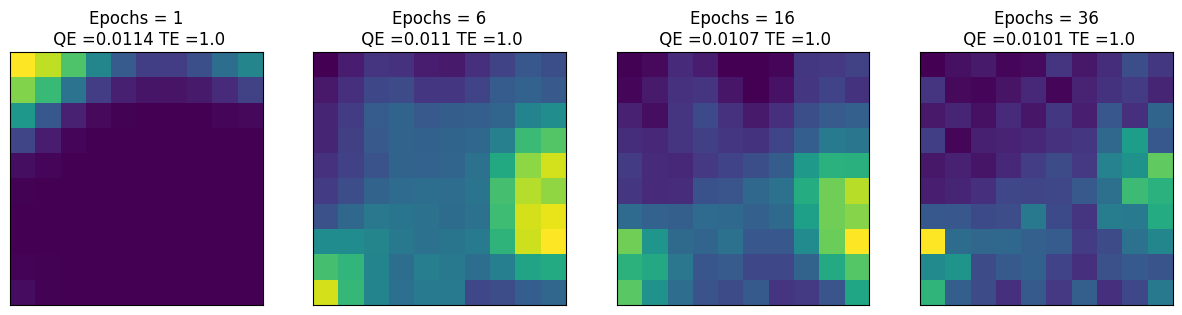

In [76]:
fig, ax = plt.subplots(
    nrows=1, ncols=4, figsize=(15, 3.5), 
    subplot_kw=dict(xticks=[], yticks=[]))
total_epochs = 0
SOMS = []
for epochs, i in zip([1, 5, 10, 20], range(0,4)):
    total_epochs += epochs
    SOM = train_SOM(SOM, n_train_data, learn_rate = .1, radius_sq = 2, epochs = epochs)
    SOMS.append(SOM)
    QE = round(calculateQE(SOM, n_train_data), 4)
    TE = round(calculateTE(SOM, n_train_data), 4)
    
    ax[i].imshow(u_matrix(SOM))
    ax[i].title.set_text('Epochs = ' + str(total_epochs) + '\n QE =' + str(QE) + ' TE =' + str(TE))

In [77]:
SOM = SOMS[1]

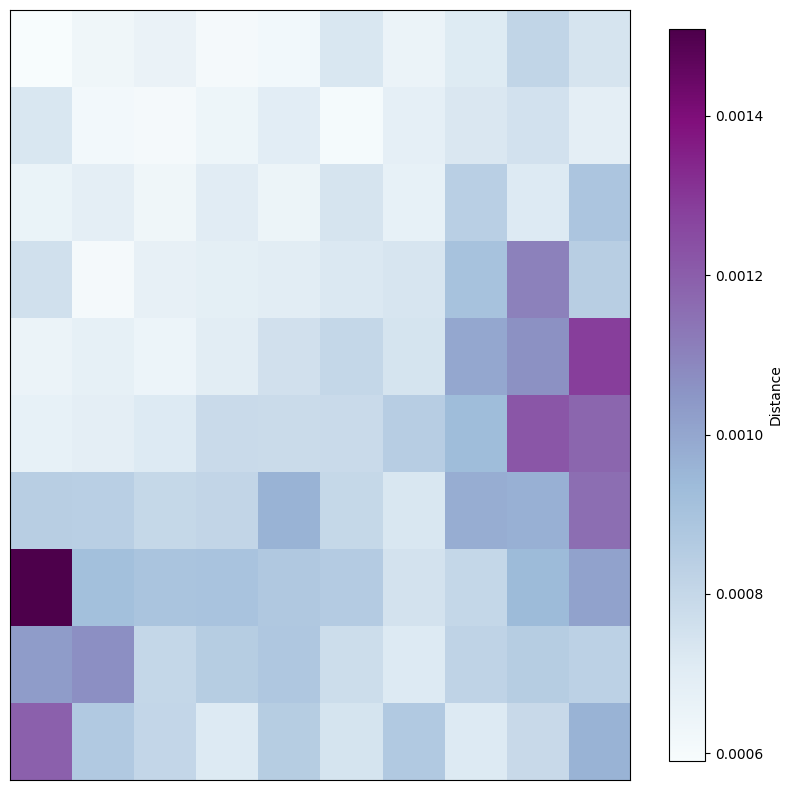

In [78]:
u_matrix_values = u_matrix(SOM)
QE = round(calculateQE(SOM, n_train_data), 4)
TE = round(calculateTE(SOM, n_train_data), 4)

plt.figure(figsize=(10, 10))
im = plt.imshow(u_matrix_values, cmap=cm.BuPu, aspect='auto')

plt.colorbar(im, shrink=0.95, label='Distance')
plt.xticks([])
plt.yticks([])
plt.show()
     

In [79]:
neuron_word_mapping = {}
for i in range(SOM.shape[0]):
    for j in range(SOM.shape[1]):
        neuron_word_mapping[(i, j)] = []

for word, vector in zip(processedDoc, reduced_matrix):
    best_matching_unit = find_BMU(SOM, vector)
    if best_matching_unit not in neuron_word_mapping:
        neuron_word_mapping[best_matching_unit] = []
    neuron_word_mapping[best_matching_unit].append(word)

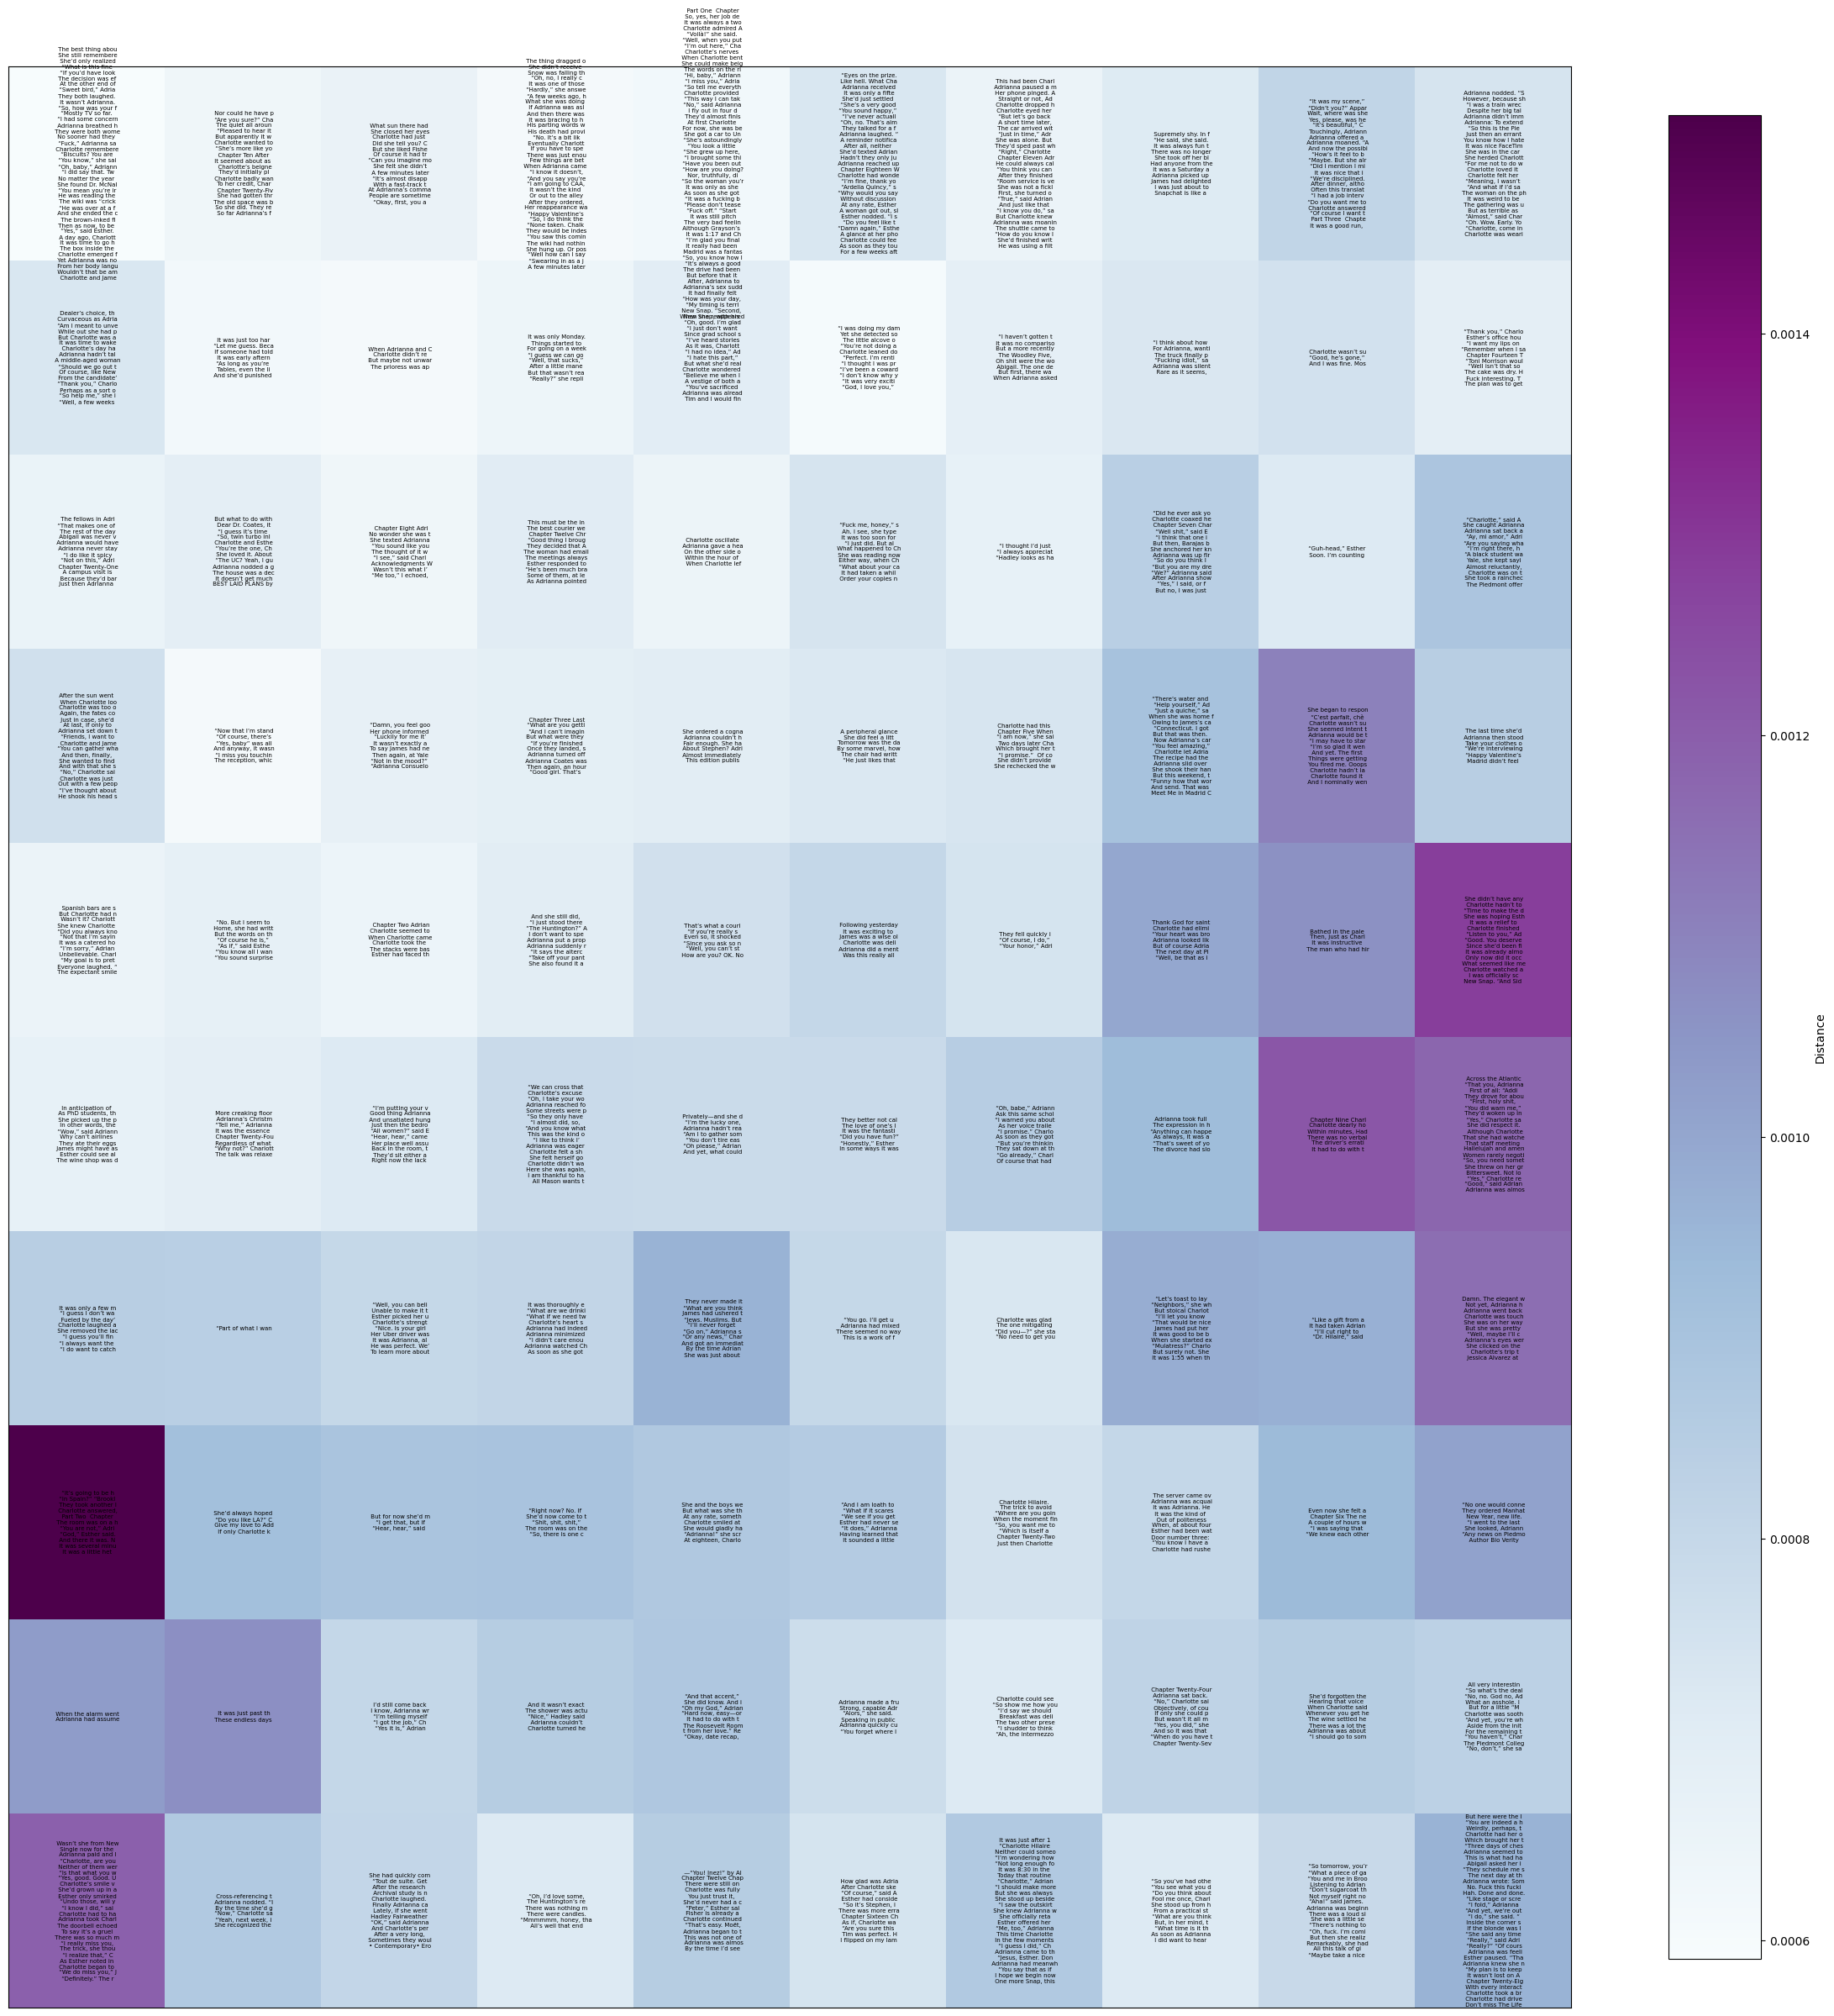

In [80]:
plt.figure(figsize=(30, 30))
im = plt.imshow(u_matrix_values, cmap=cm.BuPu, aspect='auto')
plt.colorbar(im, shrink=0.95, label='Distance')

for (i, j), words in neuron_word_mapping.items():
    # 仅显示每段文本的前几个字符
    truncated_text = [word[:20] for word in words]
    text = '\n'.join(truncated_text)
    plt.text(j, i, text, ha='center', va='center', color='black', fontsize=5)

plt.xticks([])
plt.yticks([])

# 保存图像到文件
plt.savefig('som_visualization.png', dpi=300)
plt.show()
